<a href="https://colab.research.google.com/github/KathyBees/AI_Climate/blob/main/Exercise03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise worksheet no 3

# Wildfire risk assessments for the Mediterranean

*Machine learning in climate and environmental sciences, winter semester 2024, Jun.-Prof. Peer Nowack, peer.nowack@kit.edu*

*Chair for AI in Climate and Environmental Sciences, https://ki-klima.iti.kit.edu*

**Learning goals:** This notebook will allow you to more deeply practice key machine learning concepts introduced in the lectures, focusing on a case study to assess wildfire risk in the Mediterranean. In particular, you will run a comprehensive optimization of a random forest classifier, explore the effects of spatial dependencies in cross-validation, and (optionally) work for the first time in this module with boosted trees. For this, you will use a recently published benchmark dataset designed to train and compare machine learning models for predicting wildfire risk and occurrence in the Mediterranean, called [Mesogeos](https://orion-ai-lab.github.io/mesogeos/).

#### Load Python and the "ML-climate" kernel

As always: if you are working on your own computer, now select the "ML-climate" kernel. This option should exist for you if you followed the Anaconda 3 and subsequent installation instructions provided on Ilias. Alternatively, you can run the notebook on Google Colab. As usual, you will need to use e.g. the Colab data loader whenever files need to be read from the exercise folder (see Worksheets 1 and 2), and certain packages might still need to be installed using pip.

In [1]:
# ## On Google Colab uncomment the following lines
!pip install netcdf4
!pip install cartopy
!pip install zarr
!pip install scikit-learn scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.2 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=e8a81547119eac2e06e3a0c79c639b3b1bee493f3c12b00b987ad92dc08858d0
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [2]:
# ### Please comment out after successful installation
!conda install zarr -y
!conda install fsspec -y
!conda install aiohttp -y
!conda install -c conda-forge scikit-optimize -y

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found


In [3]:
# load the required Python packages
import numpy as np
import matplotlib.pyplot as plt
import zarr
import xarray as xr
import fsspec
import requests
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score
from skopt import BayesSearchCV
import joblib
import time

#### Image from the Copernicus Sentinel-2 satellite on 19 July 2023.

During that time intense wildfires occurred in Greece, here showing a wildfire near Athens. Overall, fires around the entire country forced nearly 20,000 people to evacuate in areas west of Athens and from the island of Rhodes, and there were also smaller fires in e.g. Evia and Corfu, coinciding with a record-breaking heatwave in the Mediterranean. In terms of the area burnt, on 22 July the Greek fire season was on pair the highest figures on record, with more than [35,000 hectares burnt](https://atmosphere.copernicus.eu/greece-sees-its-most-intense-wildfire-emissions-july-record).
![03-20230720_WildfireWesternAttica (1)_0.jpg](attachment:3a5fe492-d263-4a3c-8fa0-4fa822af67f7.jpg)

Mesogeos ([link to documentation paper](https://arxiv.org/pdf/2306.05144.pdf)) provides a homogenized dataset for data-driven wildfire modelling in the Mediterranean. It integrates historical data of variables measuring wildfire drivers (meteorology, vegetation, human activity) and wildfire occurrence (actual number of wildfire ignitions, burned areas). The dataset is provided at daily temporal resolution from **1st April 2006 until 29th September 2022** (i.e. for ca. 17 years), at a high **1 km $\times$ 1 km spatial resolution.**

In the following, we will run an analysis on how well certain drivers included in the dataset could support wildfire risk assessments for a given location. While process-based fire models exist, they do come with significant biases and thus modelling uncertainties (see e.g. [Forkel et al. 2019](https://bg.copernicus.org/articles/16/57/2019/)). Data-driven modelling using machine learning therefore appears to be a promising alternative route to pursue.

However, wildfire modelling must be **intrinsically stochastic,** because conditions prone to fires need another event (ignition, e.g. due to human action, lightning, etc.) for fires to actually occur. Wildfire risk, in turn, is driven by processes of a wide range of spatial and temporal scales such as long-term drought conditions, regional and local vegetation characteristics (often referred to as **fuel** for the fire), and weather events (e.g. long-term droughts for active fuel creation vs. short-term thunderstorm ignition risk). Note that the problem is also made more complicated by potential non-stationarity: meteorological factors might change due to climate change and long-term natural variability driving trends over the observed period. Human behaviour affecting (a) **land management** that creates fuel or reduces fuel variability, and (b) **ignitions**, are known to play key roles, too.

### Data loading and exploration

The mesogeos data comes in a *datacube* format that represent the spatio-temporal nature of the data. For compression, it can be accessed online in a `zarr` file format. For more information on this array format, see e.g. this [tutorial](https://zarr.readthedocs.io/en/v2.8.1/tutorial.html). You might also find the following [info site](https://aws.amazon.com/blogs/publicsector/decrease-geospatial-query-latency-minutes-seconds-using-zarr-amazon-s3/) helpful.

We first load the mesogeos data using `xarray` and then print the data structure. As you can see, there are three coordinates (y, x, time), where *x* equals longitude in degrees east, and *y* is the latitude in degrees north. 30 variables are provided, which is still a mix of potential predictors and predictands.

Have a look at the dataset and explore its dimensions as well as the possible meaning of each variable.

In [4]:
url = 'http://i42storage-node.kiklima.iti.kit.edu:9002/mesogeos-cube/files'
ds = xr.open_zarr(fsspec.get_mapper(url),consolidated=True)
ds

<xarray.Dataset> Size: 5TB
Dimensions:               (y: 1752, x: 4714, time: 6026)
Coordinates:
  * time                  (time) datetime64[ns] 48kB 2006-04-01 ... 2022-09-29
  * x                     (x) float64 38kB -10.72 -10.71 -10.7 ... 36.73 36.74
  * y                     (y) float64 14kB 47.7 47.69 47.68 ... 30.08 30.07
Data variables: (12/30)
    aspect                (y, x) float32 33MB dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    burned_areas          (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    curvature             (y, x) float32 33MB dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    d2m                   (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    dem                   (y, x) float32 33MB dask.array<chunksize=(1752, 4714), meta=np.ndarray>
    ignition_points       (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    ...                    ...
    spatial_ref           int64 8B ...
    ssrd                  (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    t2m                   (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    tp                    (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_direction        (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>
    wind_speed            (time, y, x) float32 199GB dask.array<chunksize=(1, 1752, 4714), meta=np.ndarray>

#### First visualizations
Below we use `xarray` to visualize the *ndvi* variable for the 109th day in the dataset. This is the 19th July 2006, i.e. exactly 17 years before the day of the satellite image above.

**Task 1:** Equivalently, visualize 19/07/2006 snapshots for the following two variables: *burned_areas*,  *ssrd*. Further, visualize the variable *population* at timestep nil. Adjust the range of plotted values. You may use other [colormaps](https://matplotlib.org/stable/gallery/color/colormap_reference.html) if deemed helpful. For *burned_areas*, calculate the maximum and minimum value for that day and `print()` those values to screen. In addition, again for *burned_areas*, calculate multi-day averages (e.g. across up to 100 days, depending on your RAM available), and `print()` those to screen.

When producing multiple visualizations in one Juypter cell, make sure to find a way to actually show all figures. For example, you could create multiple axes using `fig, axs = plt.subplots(2,2)`.

CPU times: user 1.61 s, sys: 367 ms, total: 1.98 s
Wall time: 15.1 s


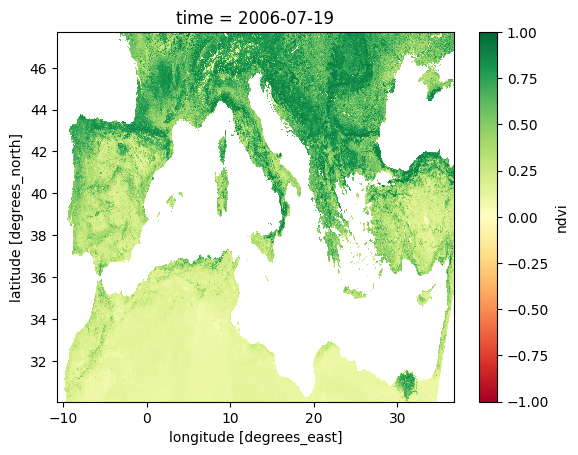

In [5]:
%%time
# plot the ndvi for the 100th day in the dataset for the whole Mediterranean
ds.sel(time='2006-07-19').ndvi.plot(cmap="RdYlGn", vmax=1, vmin=-1)
# alternatively you could also use
# ds.isel(time=109).ndvi.plot(cmap="RdYlGn", vmax=1, vmin=-1)

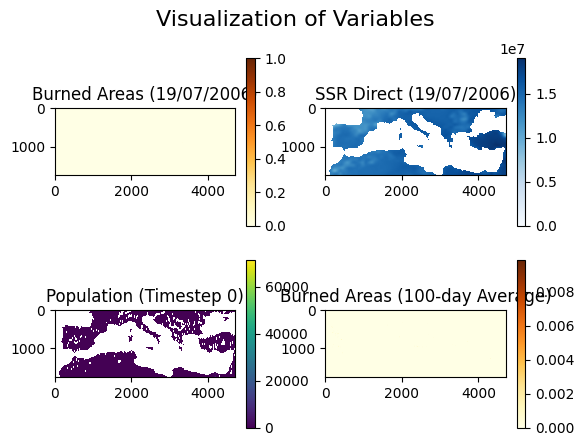

1.0
0.0
0.009900989942252636
0.0
8.128021136144525e-07


In [6]:
# Task 1
# visualize burned_areas, population, t2m.
# YOUR CODE HERE

burned_areas = ds['burned_areas']
population = ds['population']
t2m = ds['t2m']
ndvi = ds['ndvi']
ssrd = ds['ssrd']

date_of_interest = '2006-07-19'

burned_areas_day = burned_areas.sel(time=date_of_interest)
population_day = population.sel(time=date_of_interest)
t2m_day = t2m.sel(time=date_of_interest)
ndvi_day = ndvi.sel(time=date_of_interest)
ssrd_day = ssrd.sel(time=date_of_interest)

burned_areas_avg = burned_areas.sel(time=slice("2006-04-10", "2006-07-19")).mean(dim="time")
population_nil = population.isel(time=0)
ssrd_day = ssrd.sel(time=date_of_interest)

fig, axs = plt.subplots(2,2)
fig.suptitle("Visualization of Variables", fontsize=16)

burned_plot = axs[0, 0].imshow(burned_areas_day, cmap="YlOrBr", vmin=burned_areas_day.min().compute().item(), vmax=burned_areas_day.max().compute().item())
axs[0, 0].set_title("Burned Areas (19/07/2006)")
fig.colorbar(burned_plot, ax=axs[0, 0])

ssrd_plot = axs[0, 1].imshow(ssrd_day, cmap="Blues", vmin=0, vmax=ssrd_day.max().compute().item())
axs[0, 1].set_title("SSR Direct (19/07/2006)")
fig.colorbar(ssrd_plot, ax=axs[0, 1])

population_plot = axs[1, 0].imshow(population_nil, cmap="viridis", vmin=0, vmax=population_nil.max().compute().item())
axs[1, 0].set_title("Population (Timestep 0)")
fig.colorbar(population_plot, ax=axs[1, 0])

avg_plot = axs[1, 1].imshow(burned_areas_avg, cmap="YlOrBr")
axs[1, 1].set_title("Burned Areas (100-day Average)")
fig.colorbar(avg_plot, ax=axs[1, 1])

plt.show()
print(burned_areas_day.max().compute().item())
print(burned_areas_day.min().compute().item())
print(burned_areas_avg.max().compute().item())
print(burned_areas_avg.min().compute().item())
print(burned_areas_avg.mean().compute().item())

#### Understanding the variables

Let's try to understand the variables in the dataset better. The relevant section from the documentation paper reads:

*"The meteorological data (temperature, wind speed, wind direction, dewpoint temperature, surface
pressure, relative humidity, total precipitation, surface solar radiation downwards) are collected
from the ERA5-Land database [41], which contains historical hourly land weather measurements
from 1950 to today. We use day’s and night’s land surface temperature [42], Normalized Difference
Vegetation Index (NDVI) [43], and Leaf Area Index (LAI) [44] from MODIS and soil moisture
index from the European Drought Observatory (EDO) [45]. These data are used as proxies for the
vegetation status and drought. Distance from roads and population are downloaded from Worldpop
[46] and are used as indicators of human activity. At the same time, topography data, i.e. elevation,
slope, aspect, and curvature are gathered from the Copernicus DEM - Global Digital Elevation Model
(COP-DEM) [47]. The land cover classes are collected from the Copernicus Climate Change Service
[48]. The burned areas come from EFFIS. Finally, MODIS active fire [25] is used to estimate ignition
cells and the ignition date."*

**Task 2.1** Match variables in the `zarr` structure to full names from this text passage. Here, we focus on possible wildfire predictor variables. Carry out an internet search if necessary. We have prepared a dictionary of 24 keys (the short variable names) to be matched for you, as well as an unsorted list of the full names. Match the two, by updating the dictionary.

**Task 2.2** Explain the following variables in more detail, using 1-2 sentences per variable: *Dewpoint temperature at 2m*, *Relative humidity (0-1)*, *Surface solar radiation downwards (J m-2)*, *Normalized Difference Vegetation Index*, *Leaf Area Index*, *Soil moisture index*. Write to the correspondingly named and already initialized string variables.

**Task 2.3** Match each variable to one of the following three groups: (1) primarily meteorological, (2) primarily vegetation status, (3) indicators of human activity. For this, use the entries from the list `names` below. Note that we refrain from absolute statements here, since e.g. meteorological variables are often influenced by human factors, see e.g. the [urban heat island](https://www.kit.edu/kit/english/pi_2015_100_2015-heat-wave-heat-island-effect-in-karlsruhe.php).

In [7]:
# Use this cell for your answer to Task 2.1
variables = {'d2m': None, 'dem': None,
            'lai': None, 'lc_agriculture': None, 'lc_forest': None,
            'lc_grassland': None, 'lc_settlement': None, 'lc_shrubland': None, 'lc_sparse_vegetation': None,
            'lc_water_bodies': None, 'lc_wetland': None, 'lst_day': None, 'lst_night': None, 'ndvi': None,
            'population': None, 'rh': None, 'roads_distance': None, 'smi': None,
            'sp': None, 'ssrd': None, 't2m': None, 'tp': None, 'wind_direction': None, 'wind_speed': None}

names = ["Temperature at 2m above the Earth's surface (K)",\
        "Wind speed (m/s)",\
        "Wind direction (degrees)",\
        "Dewpoint temperature at 2m (K)",\
        "Surface pressure (Pa)",\
        "Relative humidity (0-1)",\
        "Total precipitation (m)",\
         "Surface solar radiation downwards (J m-2)",\
         "Day land surface temperature (K)",\
         "Night land surface temperature (K)",\
         "Normalized Difference Vegetation Index",\
         "Leaf Area Index",\
         "Soil Moisture Index",\
         "Distance from roads",\
         "Population",\
         "Land cover class agriculture (0-1)",\
         "Land cover class forest (0-1)",\
         "Land cover class grassland (0-1)",\
         "Land cover class settlement (0-1)",\
         "Land cover class shrubland (0-1)",\
         "Land cover class sparse vegetation (0-1)",\
         "Land cover class water bodies (0-1)",\
         "Land cover class wetland (0-1)",\
         "Elevation (m)",\
        ]


variables['d2m'] = names[3]
variables['dem'] = names[23]
variables['lai'] = names[11]
variables['lc_agriculture'] = names[15]
variables['lc_forest'] = names[16]
variables['lc_grassland'] = names[17]
variables['lc_settlement'] = names[18]
variables['lc_shrubland'] = names[19]
variables['lc_sparse_vegetation'] = names[20]
variables['lc_water_bodies'] = names[21]
variables['lc_wetland'] = names[22]
variables['lst_day'] = names[8]
variables['lst_night'] = names[9]
variables['ndvi'] = names[10]
variables['population'] = names[14]
variables['rh'] = names[5]
variables['roads_distance'] = names[13]
variables['smi'] = names[12]
variables['sp'] = names[4]
variables['ssrd'] = names[7]
variables['t2m'] = names[0]
variables['tp'] = names[6]
variables['wind_direction'] = names[2]
variables['wind_speed'] = names[1]


print(variables)

{'d2m': 'Dewpoint temperature at 2m (K)', 'dem': 'Elevation (m)', 'lai': 'Leaf Area Index', 'lc_agriculture': 'Land cover class agriculture (0-1)', 'lc_forest': 'Land cover class forest (0-1)', 'lc_grassland': 'Land cover class grassland (0-1)', 'lc_settlement': 'Land cover class settlement (0-1)', 'lc_shrubland': 'Land cover class shrubland (0-1)', 'lc_sparse_vegetation': 'Land cover class sparse vegetation (0-1)', 'lc_water_bodies': 'Land cover class water bodies (0-1)', 'lc_wetland': 'Land cover class wetland (0-1)', 'lst_day': 'Day land surface temperature (K)', 'lst_night': 'Night land surface temperature (K)', 'ndvi': 'Normalized Difference Vegetation Index', 'population': 'Population', 'rh': 'Relative humidity (0-1)', 'roads_distance': 'Distance from roads', 'smi': 'Soil Moisture Index', 'sp': 'Surface pressure (Pa)', 'ssrd': 'Surface solar radiation downwards (J m-2)', 't2m': "Temperature at 2m above the Earth's surface (K)", 'tp': 'Total precipitation (m)', 'wind_direction': '

In [8]:
for i in variables.keys():
    assert variables[i] is not None

In [9]:
assert variables['t2m'] == "Temperature at 2m above the Earth's surface (K)"

In [10]:
# Use this cell for your answer(s) to Task 2.2
# Explanation of variables
explanation_dewpoint = "Dewpoint shows air saturation with moisture. Low values mean dry conditions, increasing fire risk."
explanation_relative_humidity = "Relative humidity is air moisture as a percentage. Low levels create dry conditions, boosting fire risk."
explanation_surface_solar_radiation_downwards = "SSRD measures sunlight reaching the surface. High values dry vegetation, raising fire chances."
explanation_normalized_difference_vegetation_index = "NDVI indicates vegetation health. Low values mean stressed vegetation, more likely to burn."
explanation_leaf_area_index = "LAI measures vegetation density. Higher values mean more fuel, while lower ones make fires spread faster."
explanation_soil_moisture_index = "SMI shows soil water content. Low values signal drought, increasing ignition risk."
# YOUR CODE HERE


In [11]:
# Use this cell for your answer(s) to Task 2.3
list_of_primarily_meteorological_predictors = [
    't2m', 'wind_speed', 'wind_direction', 'd2m', 'sp', 'rh', 'tp', 'ssrd'
]
list_of_primarily_vegetation_status_predictors = [
    'lst_day', 'lst_night', 'ndvi', 'lai', 'smi', 'lc_forest', 'lc_grassland','lc_shrubland', 'lc_sparse_vegetation' ,
    'lc_wetland'
]
list_of_indicators_human_activity = [
    'roads_distance', 'population', 'lc_agriculture',
    'lc_settlement',  'lc_water_bodies'
]
list_of_unassignable = ['dem']
# YOUR CODE HERE


In [12]:
assert len(list_of_primarily_meteorological_predictors) > 0
assert len(list_of_primarily_vegetation_status_predictors) > 0
assert len(list_of_indicators_human_activity) > 0
assert len(list_of_unassignable) > 0

#### Preparing the data for the machine learning predictions

For computational reasons, let's now work with already prepared mesogeos datasets of labelled positive and negative cases. Specifically, detected fires within a given day and at 1 km $\times$ 1km spatial resolution are indicated whenever the variable `burned_areas` is equal to 1. Otherwise, it is set to nil. `burned_areas` will be our predictand variable.

We load these labelled datasets from two separate `csv` files using `pandas`.

In addition, we use the list of 24 predictor variables from above, which we can extract using `variables.keys()` from above and combine with the `time` and `burned_areas` column indices (which we will also need) into the list `selected_var`. However, we drop `lst_day` and `lst_night` due to otherwise many missing values in the positive cases, likely because these variables can be hard to estimate in the case of serious wildfires in a given region.

In [13]:
df_negatives = pd.read_csv("./data/negatives.csv")
df_negatives.tail()

,time,aspect,burned_areas,curvature,d2m,dem,ignition_points,lai,lst_day,lst_night,...,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,lc_wetland,population,burned_area_has,time_idx,sample
128194,2011-06-03,113.5291,0.0,36677.15,286.47717,803.9475,0.0,2.3,300.50,286.22000,...,0.0,0.0,0.0,0.0,0.0,0.0,10.624513,0.0,4.0,4273.0
128195,2011-06-04,113.5291,0.0,36677.15,288.52600,803.9475,0.0,2.3,302.44,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,10.624513,0.0,5.0,4273.0
128196,2011-06-05,113.5291,0.0,36677.15,287.49277,803.9475,0.0,2.3,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,10.624513,0.0,6.0,4273.0
128197,2011-06-06,113.5291,0.0,36677.15,285.37524,803.9475,0.0,2.3,NaN,284.28000,...,0.0,0.0,0.0,0.0,0.0,0.0,10.624513,0.0,7.0,4273.0
128198,2011-06-07,113.5291,0.0,36677.15,282.37518,803.9475,0.0,2.3,294.46,282.47998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_positives = pd.read_csv("./data/positives.csv")
df_positives = df_positives.sort_index()
print(df_positives.shape)
# drop two strange entries for later
df_positives = df_positives[df_positives['burned_areas'] < 1.1]
print(df_positives.shape)

(114757, 35)
(114756, 35)


In [15]:
selected_var = list(variables.keys())
selected_var.append('burned_areas')
selected_var.append('time')
selected_var.pop(11)
selected_var.pop(11)
print(selected_var)

['d2m', 'dem', 'lai', 'lc_agriculture', 'lc_forest', 'lc_grassland', 'lc_settlement', 'lc_shrubland', 'lc_sparse_vegetation', 'lc_water_bodies', 'lc_wetland', 'ndvi', 'population', 'rh', 'roads_distance', 'smi', 'sp', 'ssrd', 't2m', 'tp', 'wind_direction', 'wind_speed', 'burned_areas', 'time']


**Task 3.1** Create smaller dataframes by sub-selecting the `selected_var` columns from each of the two dataframes. Then drop all rows with `nan` entries, because `scikit-learn` [cannot deal with it](https://scikit-learn.org/stable/modules/impute.html). In addition, in the dataframe of positives, only select days where `burned_areas` is actually 1. The dataframe currently still contains days leading up to each event, but we will focus on simultaneous prediction only (i.e. given the values of the predictors for a given day, how likely is there going to be a wildfire).

Create a new merged dataframe `df_merged` with all these selected positive and all the negative cases from `df_negatives` using `pandas.merge()`. Make sure to merge by column name.

Then convert the column `time` to `pandas.datetime()` and use this column as the new `.index()` of the merged dataframe, and make sure to drop `time` as column using e.g. `.set_index("var", inplace=True)`. Sort the rows by this new time index.

`print()` the shape of the merged dataset to screen.

In [20]:
### subselection of variables
sub_negatives = df_negatives[selected_var]
sub_positives = df_positives[selected_var]

### delet all rows withs NANs
sub_negatives_nn = sub_negatives.dropna()
sub_positives_nn = sub_positives.dropna()

### only days where burned_areas is 1
sub_positives_ba = sub_positives_nn[sub_positives_nn['burned_areas'] == 1]
### merge negative and positive dataframe
df_merged = pd.concat([sub_negatives_nn, sub_positives_ba], axis=0, ignore_index=True)
### change time format to datetime
df_merged['time'] = pd.to_datetime(df_merged['time'])
### set time as index and sort
# df_merged.index = df_merged['time']
df_merged.set_index('time', inplace=True)
df_merged = df_merged.sort_index()

print(df_merged.shape)

(124580, 23)


#### Training, cross-validation in time, and testing the random forest classifier

**Task 3.2** Now it is time to train the random forest classifier. For this, use the `sklearn.ensemble.RandomForestClassifier()` function that we have already imported for you above, and which is documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Proceed in the following steps:

1) use data before 1st January 2019 for training and cross-validation. Use data from, and including, 1st January 2019 onwards as test data.
2) Use `BayesSearchCV()` (documentation [here](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)) in combination with `KFold()` or `StratifiedKFold()` from `sklearn` for 3-fold cross-validation. This time around set `shuffle=True` to homogenize the folds given the class imbalance. For the classifier, run the hyperparameter search over a range of values for the following parameters: `n_estimators`, `min_samples_split`, `min_samples_leaf`, `max_features`. For all other parameters, keep the default values. If you have time, try out different `scoring` methods in the `BayesSearchCV` cross-validation, e.g. the F1-score and the log-loss, see [list of scorings](https://scikit-learn.org/stable/modules/model_evaluation.html), otherwise focus on the F1-score.
A key difference to `GridSearchCV()` is that you can provide parameter ranges rather than the full grid of hyperparameter combinations to be tested for, although discrete integer values for certain hyperparameters can still be provided. By adjusting the parameter `n_iter`, you determine how much you finetune the Bayesian grid search within those hyperparameter ranges. Often, it is good to try a small number of iterations first to see how fast the computation finishes. Similarly, a strategy can be to use a smaller (not too small, e.g. 30) number of estimators first and to fit a larger number of trees for the best setting for the other parameters in the end. If the calculations still take too long (> 10 minutes), then reduce the number of training samples by randomly dropping 50% of the negatives cases above.
3) Evaluate your predictions on the test data in terms of the F1-score, log-loss, precision, and recall, which were also discussed in the lectures. Functions for this were imported above.
4) `print()` these scores on the test data to screen, with sensible descriptions. In addition, print the hyperparameters of the `best_estimator_` of the `BayesSearchCV()` object.

To speed things up, set the parameter `n_jobs` in `BayesSearchCV` to -1 if you automatically want to use all CPUs or, alternatively, to the number of CPUs you want to use (Note: if you are working on a cluster with shared node job scheduling this option will likely not work - you would have to reserve a separate node - but it will work on e.g. your local laptop). You can try to play around with `n_points`, which allows more parallel processing but uses less informed parameter combinations in each iteration.

**Note:** There are many different ways to implement a hyperparameter search, with a full grid search being the most complete but typically also most expensive option. Here you explore a Bayesian optimization as an alternative. Other examples are [`RandomizedSearchCV`](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html]) which is also offered in scikit-learn, or evolutionary algorithms.

Example timings of a student who ran this notebook across a range of hyperparameter settings:

GridSearchCV: 02:30:06

BayesSearchCV: 01:35:27

RandomizedSearch: 01:10:19

In case you cannot complete the training of the random forest object within a reasonable timeframe, we have put a trained model object saved with `joblib` in the sub-folder `data/models`. You can use this object to complete the other sub-tasks below; just uncomment the following cell. However, we ask you to still provide your code for Task 3.2 below.

In [ ]:
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# Your solution to Task 3.2
# YOUR CODE HERE

X_train = df_train.drop(columns=['burned_areas'])
y_train = df_train['burned_areas']

X_test = df_test.drop(columns=['burned_areas'])
y_test = df_test['burned_areas']

rf = RandomForestClassifier(random_state=42)

param_space = {
    'n_estimators': (50, 200),  # Number of trees
    'min_samples_split': (2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': (1, 20),  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Features to consider when looking for the best split
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

opt = BayesSearchCV(rf, param_space, n_iter=20, cv=cv, n_jobs=-1, scoring='f1', verbose=2)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
y_prob = opt.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("F1 Score:", f1)
print("Log Loss:", log_loss_value)
print("Precision:", precision)
print("Recall:", recall)
print("Best hyperparameters:", opt.best_params_)

In [30]:
# alternatively: uncomment the code below to load a trained random forest regression object
# where we used the f1-score for scoring
# use this model to make the predictions on test data requested for Task 3.2
regr_rfc_cv = joblib.load('data/models/rf_pretrained.joblib')

df_train = df_merged[df_merged.index < pd.to_datetime('2019-01-01')]
df_test = df_merged[df_merged.index >= pd.to_datetime('2019-01-01')]

X_train = df_train.drop(columns=['burned_areas'])
y_train = df_train['burned_areas']

X_test = df_test.drop(columns=['burned_areas'])
y_test = df_test['burned_areas']

print(y_test.sum())
print(y_train.sum())

# Predict on the test data
y_pred = regr_rfc_cv.predict(X_test)
y_pred_proba = regr_rfc_cv.predict_proba(X_test)

713.0
1602.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


**Task 3.3** Produce a line plot (nr_samples, y_values) which includes

- a line for the true test data labels
- a line for the predicted labels obtained using `RandomForestClassifier.predict()`
- a line for the predicted probability of a positive event using `RandomForestClassifier.predict_proba()`

for the first **300 samples** in the test set.

What do you observe? How do you explain the result? Write the answer to `explain_predictions`.

713.0


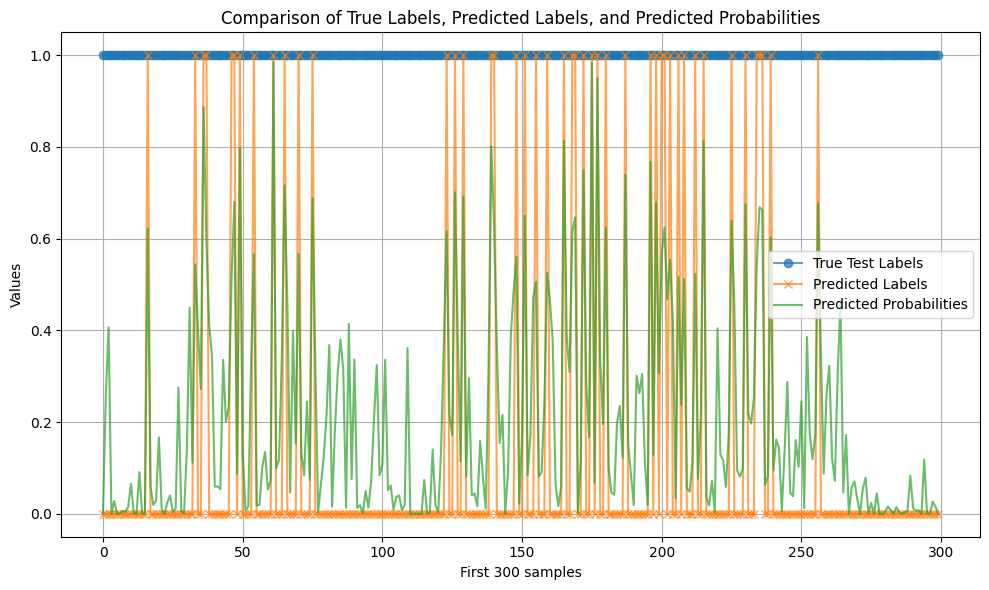

In [31]:
# Your answer to Task 3.3 goes here, including the visualization
explain_predictions = " When the propability is up, predicted label is one"

predicted_labels = regr_rfc_cv.predict(X_test[:300])
predicted_probs = regr_rfc_cv.predict_proba(X_test[:300])[:, 1]

# Prepare data for plotting
nr_samples = range(min(300, len(X_test)))
y_true = y_test[:300]

print(y_test[y_test==1].sum())

plt.figure(figsize=(10, 6))
plt.plot(nr_samples, y_true, label='True Test Labels', linestyle='-', marker='o', alpha=0.7)
plt.plot(nr_samples, predicted_labels, label='Predicted Labels', linestyle='-', marker='x', alpha=0.7)
plt.plot(nr_samples, predicted_probs, label='Predicted Probabilities', linestyle='-', alpha=0.7)

plt.title('Comparison of True Labels, Predicted Labels, and Predicted Probabilities')
plt.xlabel('First 300 samples')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
assert len(explain_predictions) > 0

**Task 3.4** Repeat the procedure from Task 3.2, but this time using the `sklearn.model_selection.train_test_split` method to create your training and test datasets, documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), imported above. Set `shuffle=True` and use 80% of the data for training/cross-validation and 20% for testing.

Compare your results to Task 3.2. What do you observe and what is the most likely explanation for this result? Write your answer to `explain_train_test_split`.

Again we have made a pre-trained model available in `data/models`, which you can use to calculate results on top of providing your own code (without finalizing the training).

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.1 when using version 1.5.2. This might lead to b

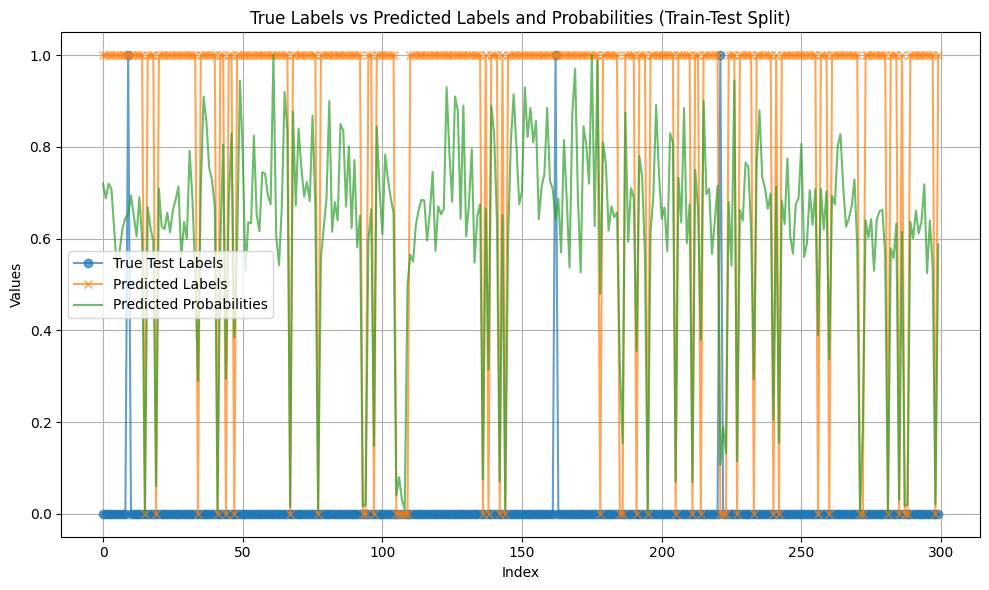

In [38]:
# Your solution to Task 3.4
regr_rfc_cv = joblib.load('./data/models/rf_pretrained_train_test_split_shuffle.joblib')
explain_train_test_split = "Split arrays or matrices into random train and test subsets, compared to slicing by time which allows for more accurate representations"

x = df_merged.drop(columns=['burned_areas'])
y = df_merged['burned_areas']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)


# Predictions
predicted_labels = regr_rfc_cv.predict(X_test)
predicted_probs = regr_rfc_cv.predict_proba(X_test)[:, 1]

nr_samples = range(min(300, len(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(nr_samples, y_test[:300], label='True Test Labels', linestyle='-', marker='o', alpha=0.7)
plt.plot(nr_samples, predicted_labels[:300], label='Predicted Labels', linestyle='-', marker='x', alpha=0.7)
plt.plot(nr_samples, predicted_probs[:300], label='Predicted Probabilities', linestyle='-', alpha=0.7)

plt.title('True Labels vs Predicted Labels and Probabilities (Train-Test Split)')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Task 3.5** Suggest a few steps that could help to improve the random forest classifier.

In [41]:
answer_improve = "The RFC can be improved by using more data, but at the same time looking out for the curse of dimensionality. As well as outlierdetection, and different tuning of hyperparameters"
# YOUR CODE HERE

In [ ]:
assert len(answer_improve) > 0

**Task 4 (Optional)** Try to improve on your model from Task 3.2.

A first option could be the use of a boosted tree classifier such as `sklearn.ensemble.AdaBoostClassifier()`, documented [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), or `XGBoost()`. For the latter, you can find many online resources, e.g. this [blog post](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/). Finally, you might also explore one of the many ways to [visualize decision trees](https://www.codementor.io/@mgalarny/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-154mszcto7).

**Include a note in your submission details if you attempted this task.**

The best solution(s) will be highlighted in the exercise class :)

In [ ]:
# Task 4 solution here
# YOUR CODE HERE
raise NotImplementedError()